In [1]:
import numpy as np
import os
import random
from tqdm import tqdm

folder = '/beagle3/dinner/zpengmei/insulin/feats_reduced'

# Function to process each file
def process_file(filename):
    data = np.load(filename, mmap_mode='r')
    try:
        feature = data['features_masked']
        return feature
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None
    finally:
        data.close()

# Listing files
traj_list = [f for f in os.listdir(folder) if f.endswith('.npz')]


# Use list comprehension to construct the list, handling files where data is correctly processed
data_list = [feature for traj in tqdm(traj_list) if (feature := process_file(os.path.join(folder, traj))) is not None]

# Now data_list contains all the processed arrays.
print(f"Processed {len(data_list)} files.")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 781/781 [02:50<00:00,  4.58it/s]

Processed 781 files.


In [2]:
# a simple MLP VAMP head

import torch.nn as nn
import torch.nn.functional as F
from geom2vec.models.subformer_prot import SubFormer_Prot

class Net(nn.Module):
    def __init__(self,out_channels, hidden_channels, encoder_layers, nhead, dim_feedforward, dropout=0.1):
        super(Net, self).__init__()
        self.subformer = SubFormer_Prot(hidden_channels=hidden_channels, 
                                        encoder_layers=encoder_layers,
                                        nhead=nhead,
                                        dim_feedforward=dim_feedforward, 
                                        dropout=dropout)
        self.vamp_head = VAMPHead(hidden_channels, out_channels, hidden_channels)

    def forward(self, x):

        x = self.subformer(x)
        x = self.vamp_head(x)
        return x

class VAMPHead(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(VAMPHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim//2, hidden_dim//4)
        self.fc3 = nn.Linear(hidden_dim//4, output_dim)
        self.activation = nn.SiLU()


    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x



In [3]:
# all right, that's linear method, let's try out nonlinear method like VAMPNets
# import vampnet and dataset class
from deeptime.decomposition.deep import VAMPNet
from deeptime.util.data import TrajectoriesDataset
import torch

# create dataset
train_data = TrajectoriesDataset.from_numpy(10,data_list[20:])
valid_data = TrajectoriesDataset.from_numpy(10,data_list[:20])




In [4]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from copy import deepcopy

loader_train = DataLoader(train_data, batch_size=500, shuffle=True)
loader_val = DataLoader(valid_data, batch_size=500, shuffle=False)

lobe = Net(out_channels=5, hidden_channels=256, encoder_layers=6, nhead=8, dim_feedforward=512,dropout=0.2)
lobe_lagged = deepcopy(lobe)

# create VAMPNet
device = ('cuda' if torch.cuda.is_available() else 'cpu')
lobe.to(device)
lobe_lagged.to(device)

vampnet = VAMPNet(lobe=lobe,lobe_timelagged=lobe_lagged, learning_rate=1e-4, device=device)
model = vampnet.fit(loader_train, n_epochs=5,validation_loader=loader_val, progress=tqdm).fetch_model()

/project/dinner/zpengmei/conda_envs/torch/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


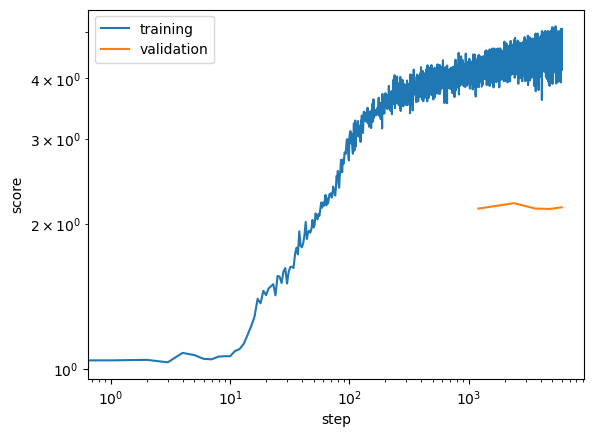

In [5]:
import matplotlib.pyplot as plt

plt.loglog(*vampnet.train_scores.T, label='training')
plt.loglog(*vampnet.validation_scores.T, label='validation')
plt.xlabel('step')
plt.ylabel('score')
plt.legend()

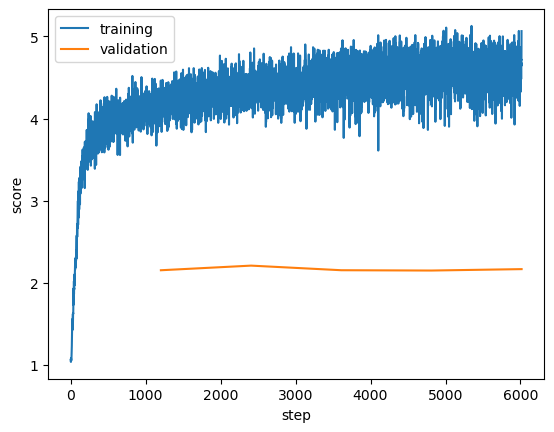

In [6]:
plt.plot(*vampnet.train_scores.T, label='training')
plt.plot(*vampnet.validation_scores.T, label='validation')
plt.xlabel('step')
plt.ylabel('score')
plt.legend()

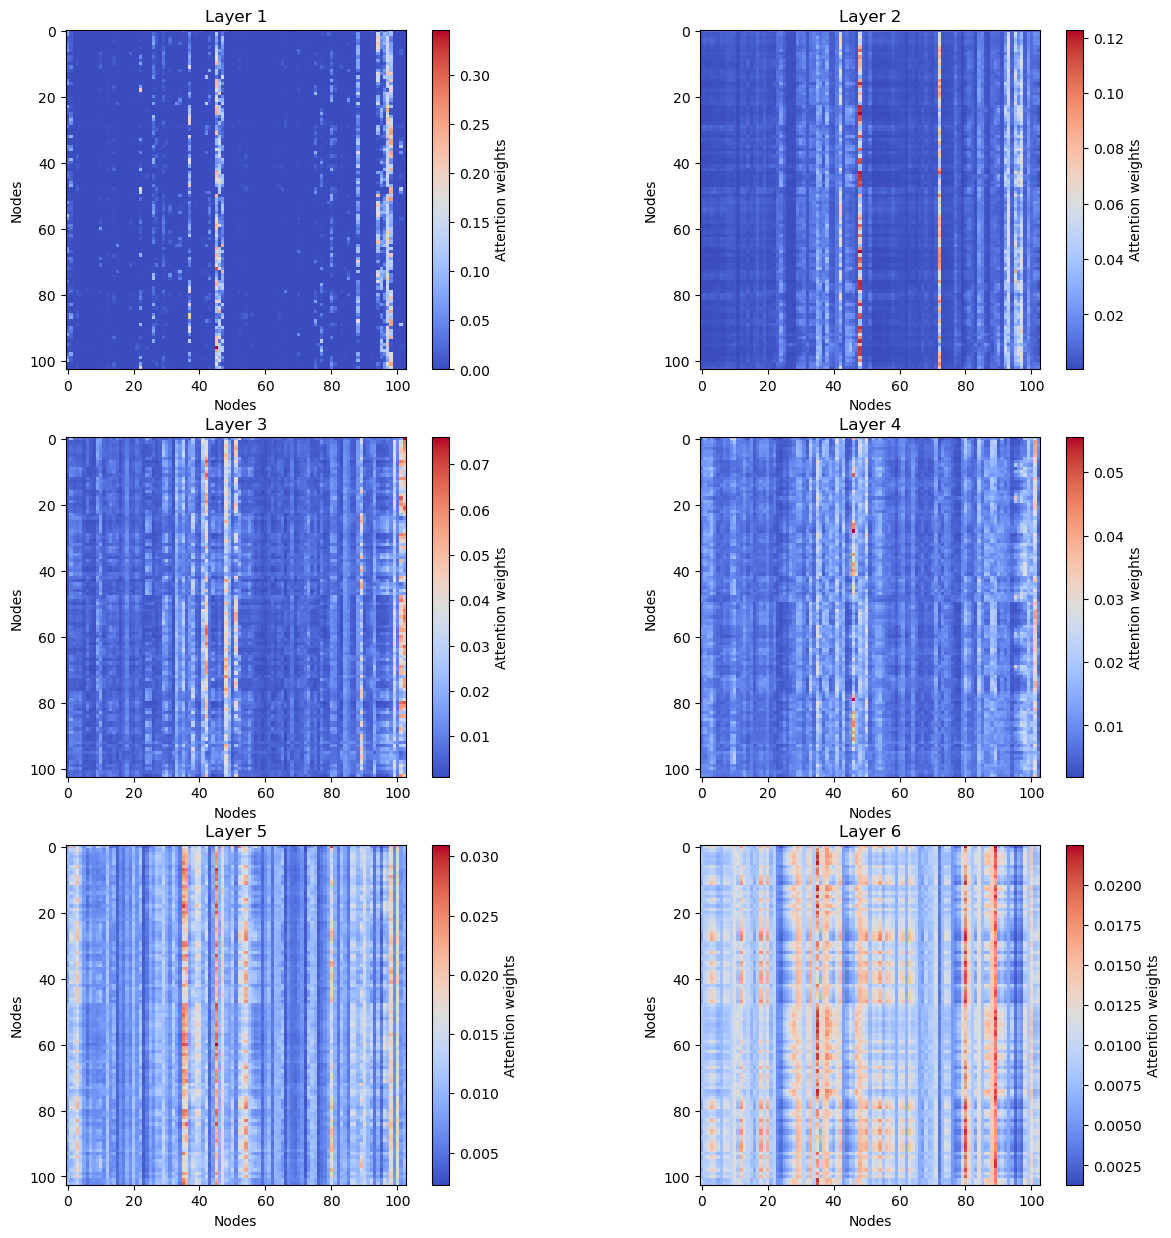

In [7]:
# show the attention weights from 6 layers using plt heat map in subplots
attn_weights = lobe.subformer.get_weights(torch.from_numpy(data_list[1][80:81]).to(device))
attn_weights = torch.stack(attn_weights, dim=0)
attn_weights_sample = attn_weights[:,0,:200,:200].cpu().detach().numpy()

import matplotlib.pyplot as plt


fig, axs = plt.subplots(3, 2, figsize=(15, 15))
for i in range(6):
    axs[i//2,i%2].imshow(attn_weights_sample[i],cmap='coolwarm', interpolation='nearest')
    axs[i//2,i%2].set_title(f'Layer {i+1}')
    # color bar
    cbar = plt.colorbar(axs[i//2,i%2].imshow(attn_weights_sample[i],cmap='coolwarm', interpolation='nearest'), ax=axs[i//2,i%2])
    cbar.set_label('Attention weights')
    axs[i//2,i%2].set_xlabel('Nodes')
    axs[i//2,i%2].set_ylabel('Nodes')

# overall title
plt.show()


In [8]:
vamp_features = model.transform(data_list)


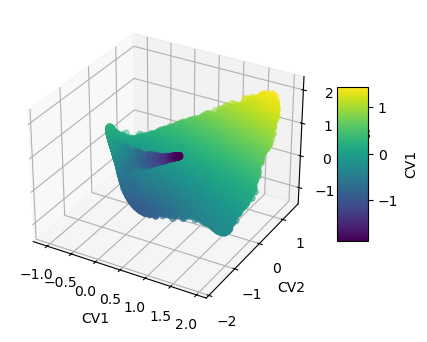

In [9]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Assuming g is your dataset with columns or CV1, CV2, and Z
g = np.concatenate(vamp_features, axis=0)
# g = graphvampnets_cvs
X = g[:, 0]
Y = g[:, 1]
Z = g[:, 2]

# Creating a 3D scatter plot
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(X, Y, Z, c=Y, cmap='viridis', marker='o')

ax.set_xlabel('CV1')
ax.set_ylabel('CV2')
ax.set_zlabel('CV3')

# Adding a color bar to represent the values of Z
cbar = fig.colorbar(scatter, shrink=0.5, aspect=5)
cbar.set_label('CV1')

plt.show()

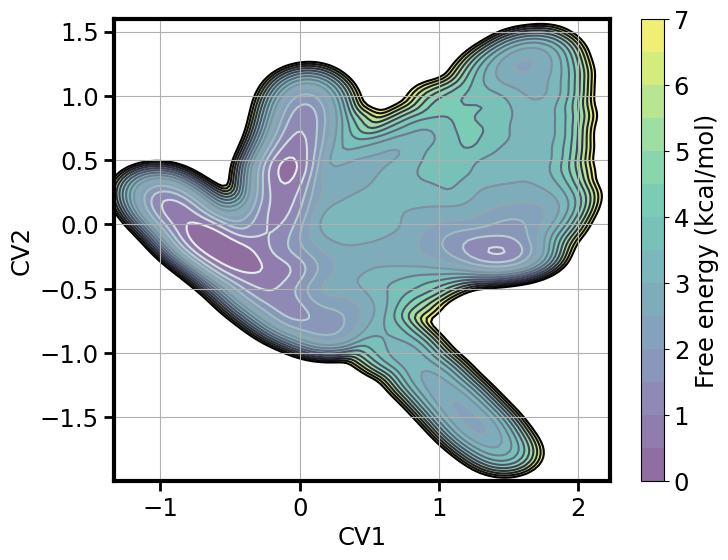

In [11]:
from matplotlib import pyplot as plt
from geom2vec.utils import ContourPlot2D
# g = np.concatenate(graphvampnets_cvs)
fig, ax = plt.subplots(1,1,figsize=(8,6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
#ax.set_aspect('equal', adjustable='box')
ax.xaxis.set_tick_params(labelsize=17.5,direction='out',length=7.5,width=2)
ax.yaxis.set_tick_params(labelsize=17.5,direction='out',length=7.5,width=2)
c = ContourPlot2D()
ax = c.plot(g[:,0:2][::5],ax,labelsize=17.5,xlabel='CV1',ylabel='CV2')

In [13]:
# save the lobe and lobe_lagged
torch.save(lobe.state_dict(), '/project/dinner/zpengmei/geom2vec/Tutorial/insulin_lobe.pth')
torch.save(lobe_lagged.state_dict(), '/project/dinner/zpengmei/geom2vec/Tutorial/insulin_lobe_lagged.pth')

In [16]:
mlp_data_list = []
# sum the dim 1 in the data_list elements
for i in range(len(data_list)):
    mlp_data_list.append(np.sum(data_list[i], axis=1))
    

In [17]:
# a simple MLP VAMP head

import torch.nn as nn
import torch.nn.functional as F

class VAMPHead(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(VAMPHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim//2, hidden_dim//4)
        self.fc3 = nn.Linear(hidden_dim//4, output_dim)
        self.activation = nn.SiLU()


    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


In [18]:
# all right, that's linear method, let's try out nonlinear method like VAMPNets
# import vampnet and dataset class
from deeptime.decomposition.deep import VAMPNet
from deeptime.util.data import TrajectoriesDataset
import torch

# create dataset
train_data = TrajectoriesDataset.from_numpy(10,mlp_data_list[20:])
valid_data = TrajectoriesDataset.from_numpy(10,mlp_data_list[:20])


In [20]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from copy import deepcopy

loader_train = DataLoader(train_data, batch_size=500, shuffle=True)
loader_val = DataLoader(valid_data, batch_size=500, shuffle=False)

lobe = VAMPHead(input_dim=256, output_dim=5, hidden_dim=256)
lobe_lagged = deepcopy(lobe)

# create VAMPNet
device = ('cuda' if torch.cuda.is_available() else 'cpu')
lobe.to(device)
lobe_lagged.to(device)

vampnet = VAMPNet(lobe=lobe,lobe_timelagged=lobe_lagged, learning_rate=1e-4, device=device)
model = vampnet.fit(loader_train, n_epochs=5,validation_loader=loader_val, progress=tqdm).fetch_model()

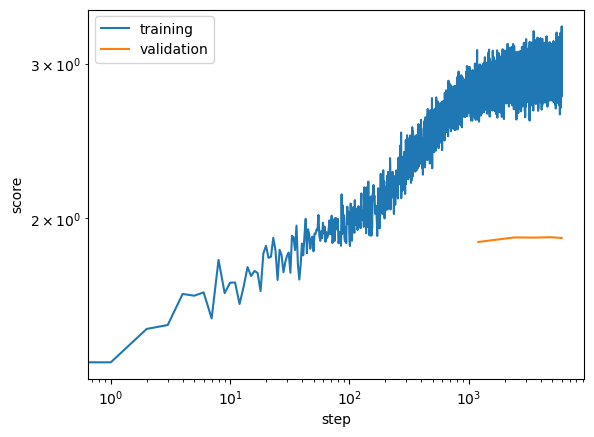

In [21]:
import matplotlib.pyplot as plt

plt.loglog(*vampnet.train_scores.T, label='training')
plt.loglog(*vampnet.validation_scores.T, label='validation')
plt.xlabel('step')
plt.ylabel('score')
plt.legend()

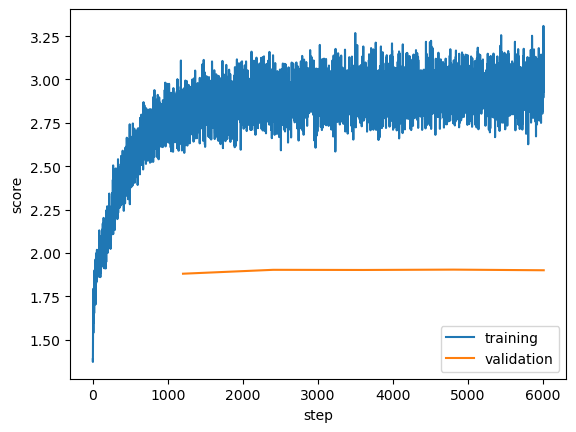

In [22]:
plt.plot(*vampnet.train_scores.T, label='training')
plt.plot(*vampnet.validation_scores.T, label='validation')
plt.xlabel('step')
plt.ylabel('score')
plt.legend()

In [24]:
vamp_features = model.transform(mlp_data_list)


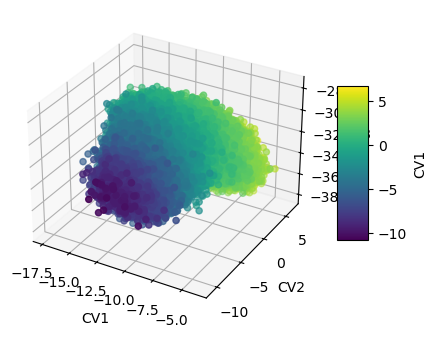

In [25]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Assuming g is your dataset with columns or CV1, CV2, and Z
g = np.concatenate(vamp_features, axis=0)
# g = graphvampnets_cvs
X = g[:, 0]
Y = g[:, 1]
Z = g[:, 2]

# Creating a 3D scatter plot
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(X, Y, Z, c=Y, cmap='viridis', marker='o')

ax.set_xlabel('CV1')
ax.set_ylabel('CV2')
ax.set_zlabel('CV3')

# Adding a color bar to represent the values of Z
cbar = fig.colorbar(scatter, shrink=0.5, aspect=5)
cbar.set_label('CV1')

plt.show()

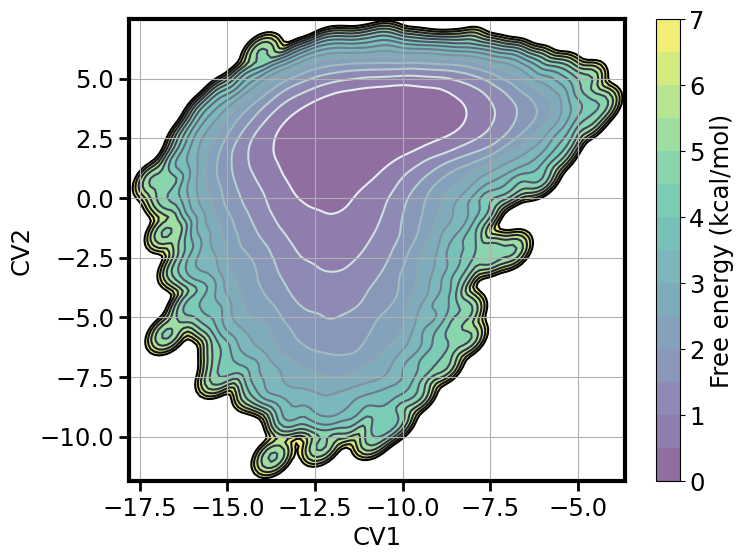

In [26]:
from matplotlib import pyplot as plt
from geom2vec.utils import ContourPlot2D
# g = np.concatenate(graphvampnets_cvs)
fig, ax = plt.subplots(1,1,figsize=(8,6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
#ax.set_aspect('equal', adjustable='box')
ax.xaxis.set_tick_params(labelsize=17.5,direction='out',length=7.5,width=2)
ax.yaxis.set_tick_params(labelsize=17.5,direction='out',length=7.5,width=2)
c = ContourPlot2D()
ax = c.plot(g[:,0:2][::5],ax,labelsize=17.5,xlabel='CV1',ylabel='CV2')